In [ ]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

## First we make our custom dataset

In [ ]:
# Setting random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 100000

# Generate numerical features
age = np.random.randint(18, 70, size=num_points).astype(float)
education_years = np.random.randint(10, 20, size=num_points).astype(float)
experience_years = np.random.randint(0, 50, size=num_points).astype(float)
hours_worked = np.random.randint(20, 80, size=num_points).astype(float)
commute_time = np.random.randint(10, 120, size=num_points).astype(float)

# Introduce outliers
outlier_indices = np.random.choice(num_points, size=int(0.05 * num_points), replace=False)
for feature in [education_years, experience_years, hours_worked, commute_time]:
    feature[outlier_indices] *= 2

# Introduce missing values
missing_indices = np.random.choice(num_points, size=int(0.1 * num_points), replace=False)
for feature in [age, education_years, experience_years, hours_worked, commute_time]:
    feature[missing_indices] = np.nan

# Generate categorical features
states = ['CA', 'NY', 'TX', 'FL', 'IL']
education_levels = ['High School', 'Associate', 'Bachelor', 'Master', 'PhD']
occupation = ['Software Engineer', 'Doctor', 'Teacher', 'Sales Representative', 'Nurse']

state = np.random.choice(states, size=num_points)
education = np.random.choice(education_levels, size=num_points)
job_title = np.random.choice(occupation, size=num_points)

# Generate salaries based on features
# Let's create a target variable as a linear combination of features with some noise
salaries = 50000 + age * 1000 + education_years * 500 + experience_years * 1000 + hours_worked * 50
salaries += np.random.normal(loc=0, scale=10000, size=num_points)

# Combine features into a DataFrame
data = {
    'Age': age,
    'EducationYears': education_years,
    'ExperienceYears': experience_years,
    'HoursWorkedWeekly': hours_worked,
    'CommuteTimeMinutes': commute_time,
    'State': state,
    'EducationLevel': education,
    'JobTitle': job_title,
    'SalaryUSD': salaries
}
df = pd.DataFrame(data)


## Data Assesment

In [ ]:
df.head()

,Age,EducationYears,ExperienceYears,HoursWorkedWeekly,CommuteTimeMinutes,State,EducationLevel,JobTitle,SalaryUSD
0,56.0,13.0,2.0,31.0,33.0,IL,PhD,Sales Representative,113651.499904
1,69.0,11.0,26.0,74.0,102.0,CA,Bachelor,Sales Representative,150812.545179
2,46.0,18.0,42.0,79.0,21.0,CA,Associate,Sales Representative,139168.976778
3,32.0,14.0,41.0,64.0,34.0,NY,High School,Teacher,139829.864761
4,60.0,12.0,48.0,73.0,82.0,NY,PhD,Doctor,168962.608956


In [ ]:
df.shape

(100000, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 90000 non-null   float64
 1   EducationYears      90000 non-null   float64
 2   ExperienceYears     90000 non-null   float64
 3   HoursWorkedWeekly   90000 non-null   float64
 4   CommuteTimeMinutes  90000 non-null   float64
 5   State               100000 non-null  object 
 6   EducationLevel      100000 non-null  object 
 7   JobTitle            100000 non-null  object 
 8   SalaryUSD           90000 non-null   float64
dtypes: float64(6), object(3)
memory usage: 6.9+ MB


In [ ]:
df.describe()

,Age,EducationYears,ExperienceYears,HoursWorkedWeekly,CommuteTimeMinutes,SalaryUSD
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,43.488178,15.215567,25.825056,51.915144,67.710833,129545.199940
std,14.960042,4.420574,16.448874,21.517497,36.717823,24985.673536
min,18.000000,10.000000,0.000000,20.000000,10.000000,45762.809670
25%,31.000000,12.000000,12.000000,35.000000,38.000000,112165.960916
50%,43.000000,15.000000,25.000000,51.000000,66.000000,128920.689533
75%,56.000000,17.000000,38.000000,66.000000,94.000000,145747.046773
max,69.000000,38.000000,98.000000,158.000000,238.000000,255388.484281


In [1]:
df.isnull().sum()

NameError: name 'df' is not defined

In [ ]:
df.duplicated().sum()

9875

In [ ]:
for col in df.select_dtypes(include=["int","float"]):
  skewness = df[col].skew()
  if skewness == 0:
    print(f"{col} is normally distributed")
  elif -0.5 < skewness < 0.5:
    print(f"{col} is almost normal skewed with skewness of : {skewness}")
  elif -1 < skewness < 1:
    print(f"{col} is moderately skewned with skewness of : {skewness}")
  else:
    print(f"{col} is highly skewed with skewness of : {skewness}")

Age is almost normal skewed with skewness of : 0.0025010437681211683
EducationYears is highly skewed with skewness of : 2.1105099958505713
ExperienceYears is moderately skewned with skewness of : 0.6528094829867447
HoursWorkedWeekly is highly skewed with skewness of : 1.1702609978682514
CommuteTimeMinutes is moderately skewned with skewness of : 0.7598698770611497
SalaryUSD is almost normal skewed with skewness of : 0.30643446891903753


In [ ]:
for col in df.select_dtypes(include=["int", "float"]):
    correlation = df[col].corr(df["SalaryUSD"])*100
    print(f"{col} correlation with SalaryUSD: {correlation}")

Age correlation with SalaryUSD: 60.00667354009638
EducationYears correlation with SalaryUSD: 26.06407929565833
ExperienceYears correlation with SalaryUSD: 68.56593816770345
HoursWorkedWeekly correlation with SalaryUSD: 18.56947261663517
CommuteTimeMinutes correlation with SalaryUSD: 11.456488248244414
SalaryUSD correlation with SalaryUSD: 100.0


### Conclusions
- Data set has 10k missing values in columns Age, EducationYears,ExperienceYears, HoursWorkedWeekly,CommuteTimeMinutes,SalaryUSD.
- All numerical columns are positively correlated with the salary column.
- Beside age column mostly can be considered as skewed column



## Exploratory Data Analysis

In [ ]:
cat_cols = [
    col for col in df.columns if df[col].dtypes == "object"
]

In [ ]:
cat_cols

['State', 'EducationLevel', 'JobTitle']

<Axes: xlabel='JobTitle'>

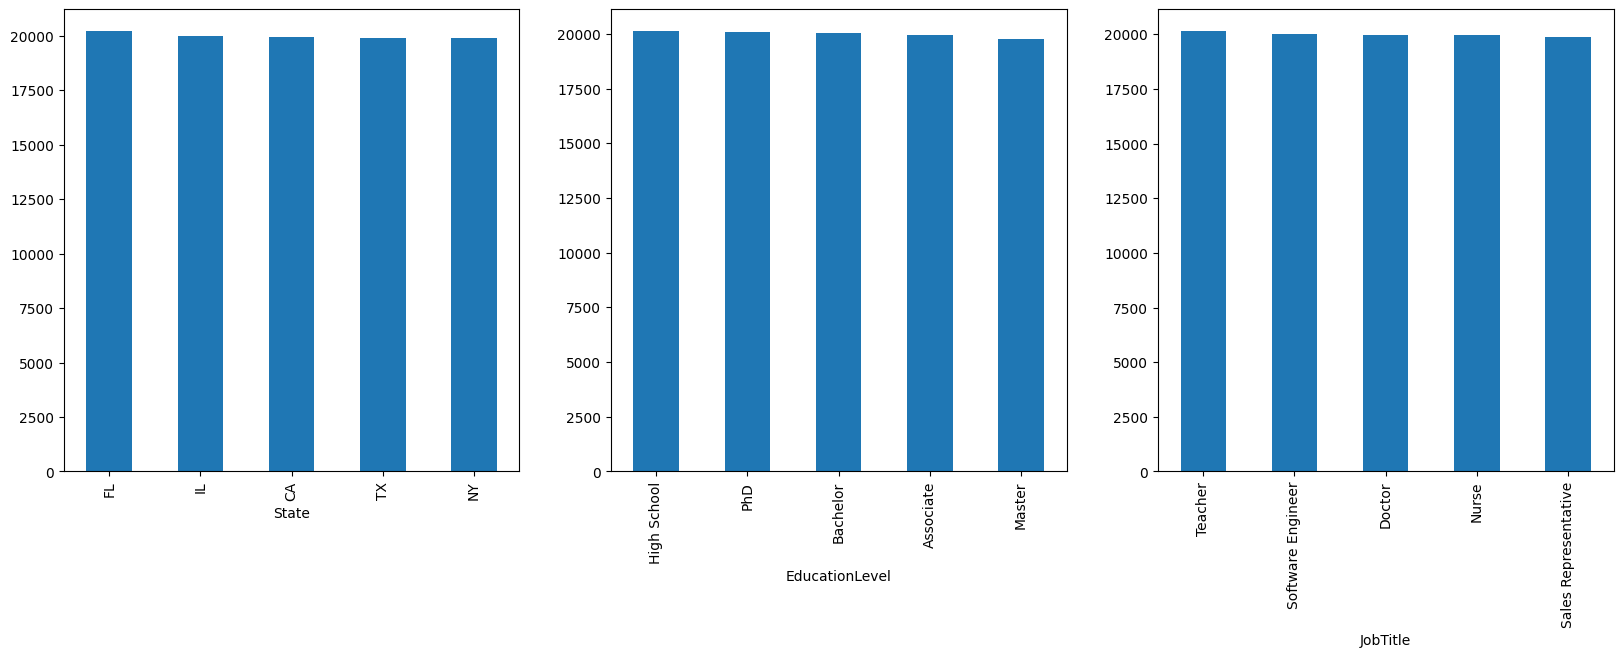

In [13]:
plt.figure(figsize=(20,6))

plt.subplot(131)
df["State"].value_counts().sort_values(ascending=False).plot(kind="bar")

plt.subplot(132)
df["EducationLevel"].value_counts().sort_values(ascending=False).plot(kind="bar")

plt.subplot(133)
df["JobTitle"].value_counts().sort_values(ascending=False).plot(kind="bar")

In [14]:
num_cols = [

            col for col in df.columns if df[col].dtypes in ["int","float"]
]

In [15]:
num_cols

['Age',
 'EducationYears',
 'ExperienceYears',
 'HoursWorkedWeekly',
 'CommuteTimeMinutes',
 'SalaryUSD']

<Axes: xlabel='SalaryUSD', ylabel='Density'>

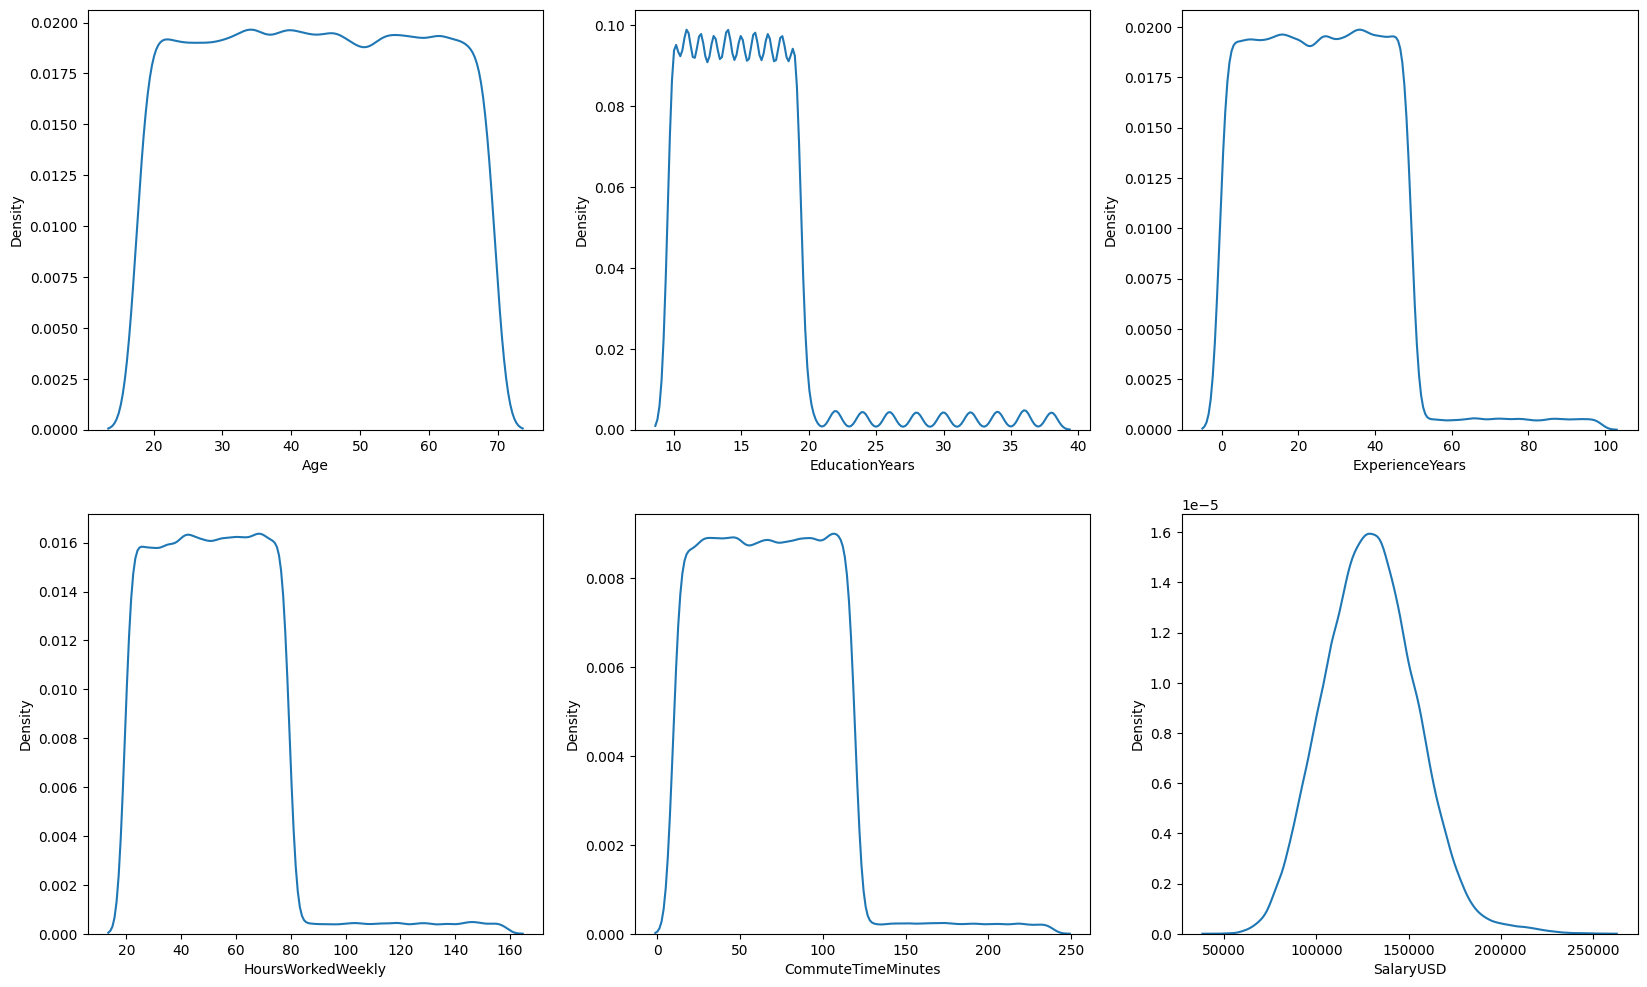

In [16]:
plt.figure(figsize=(20,12))

plt.subplot(231)
sns.kdeplot(df["Age"])

plt.subplot(232)
sns.kdeplot(df["EducationYears"])

plt.subplot(233)
sns.kdeplot(df["ExperienceYears"])

plt.subplot(234)
sns.kdeplot(df["HoursWorkedWeekly"])

plt.subplot(235)
sns.kdeplot(df["CommuteTimeMinutes"])

plt.subplot(236)
sns.kdeplot(df["SalaryUSD"])

## Conclusion

- Most columns are right skewed.
- Age is normal with a wide spread.
- Salary column is most normal in these

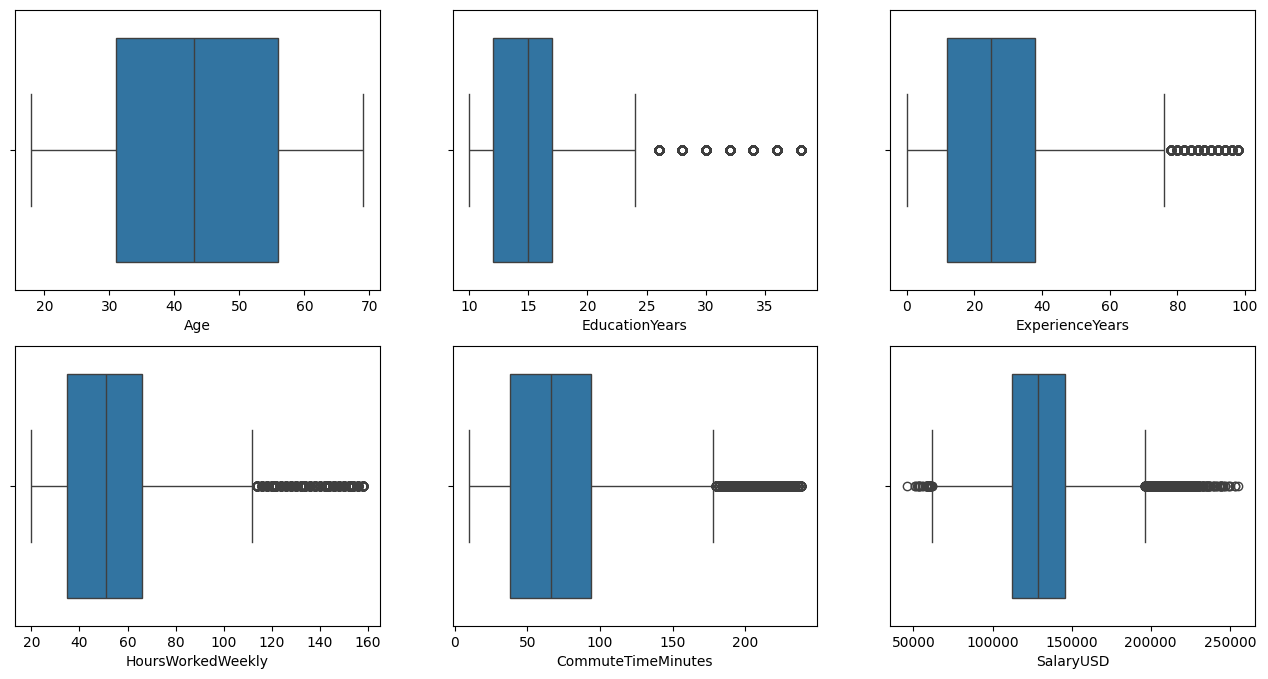

In [17]:
num_cols = ['Age', 'EducationYears', 'ExperienceYears', 'HoursWorkedWeekly',"CommuteTimeMinutes","SalaryUSD"]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    sns.boxplot(data=df, x=df[column], ax=ax[index])

plt.show()


## Conclusion
- Beside Age all other columns has outliers in them.

Text(0, 0.5, 'Salaries')

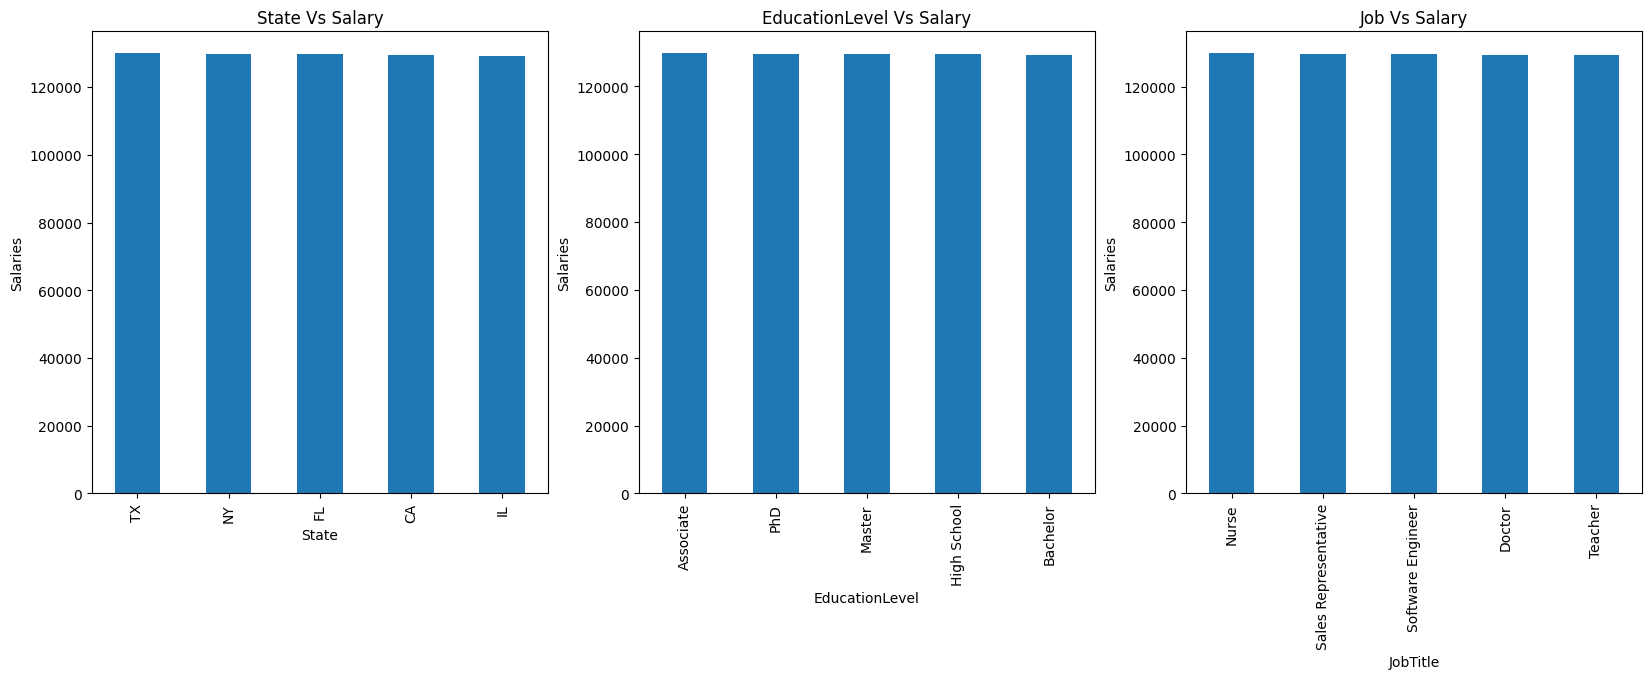

In [18]:
plt.figure(figsize=(20,6))

plt.subplot(131)
df.groupby("State")["SalaryUSD"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("State Vs Salary")
plt.ylabel("Salaries")

plt.subplot(132)
df.groupby("EducationLevel")["SalaryUSD"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("EducationLevel Vs Salary")
plt.ylabel("Salaries")

plt.subplot(133)
df.groupby("JobTitle")["SalaryUSD"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Job Vs Salary")
plt.ylabel("Salaries")

## Conclsuions
- Tx has the highest salary on average.
- Associate has the highest salary on average.
- Nurse has the highest salary on average.

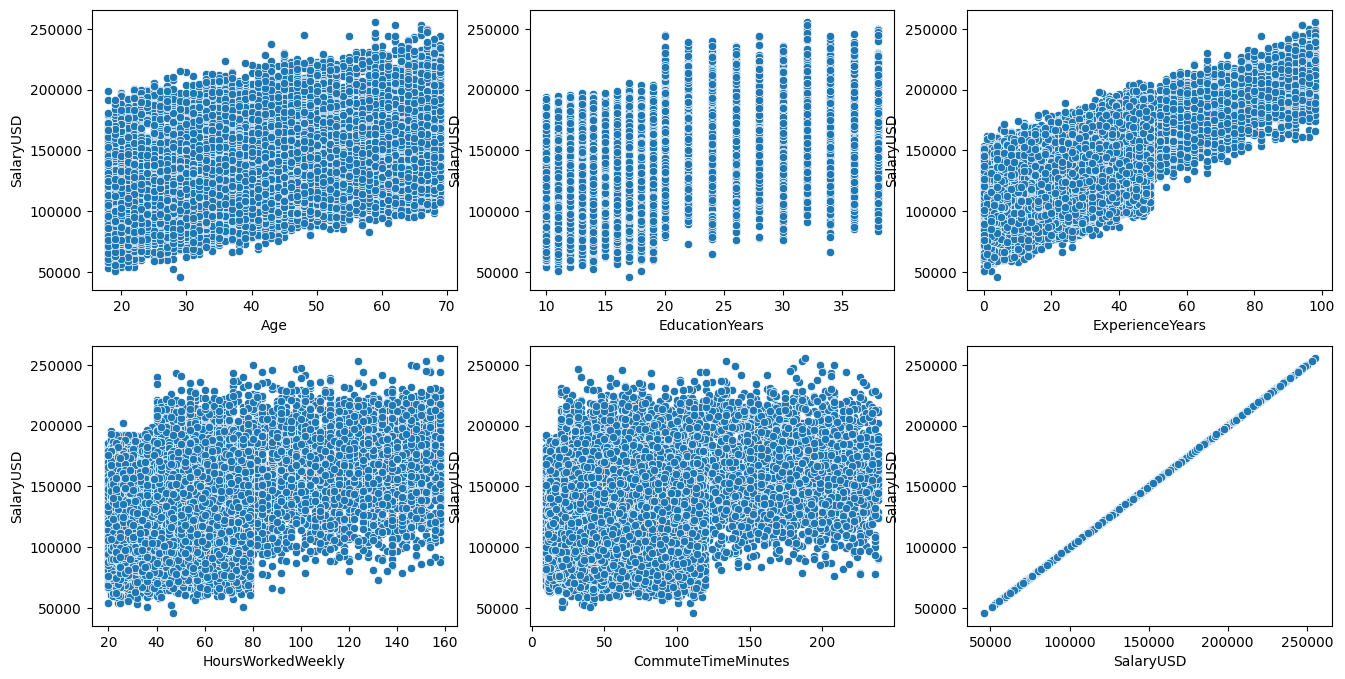

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    sns.scatterplot(data=df, x=df[column], y="SalaryUSD", ax=ax[index])

plt.show()

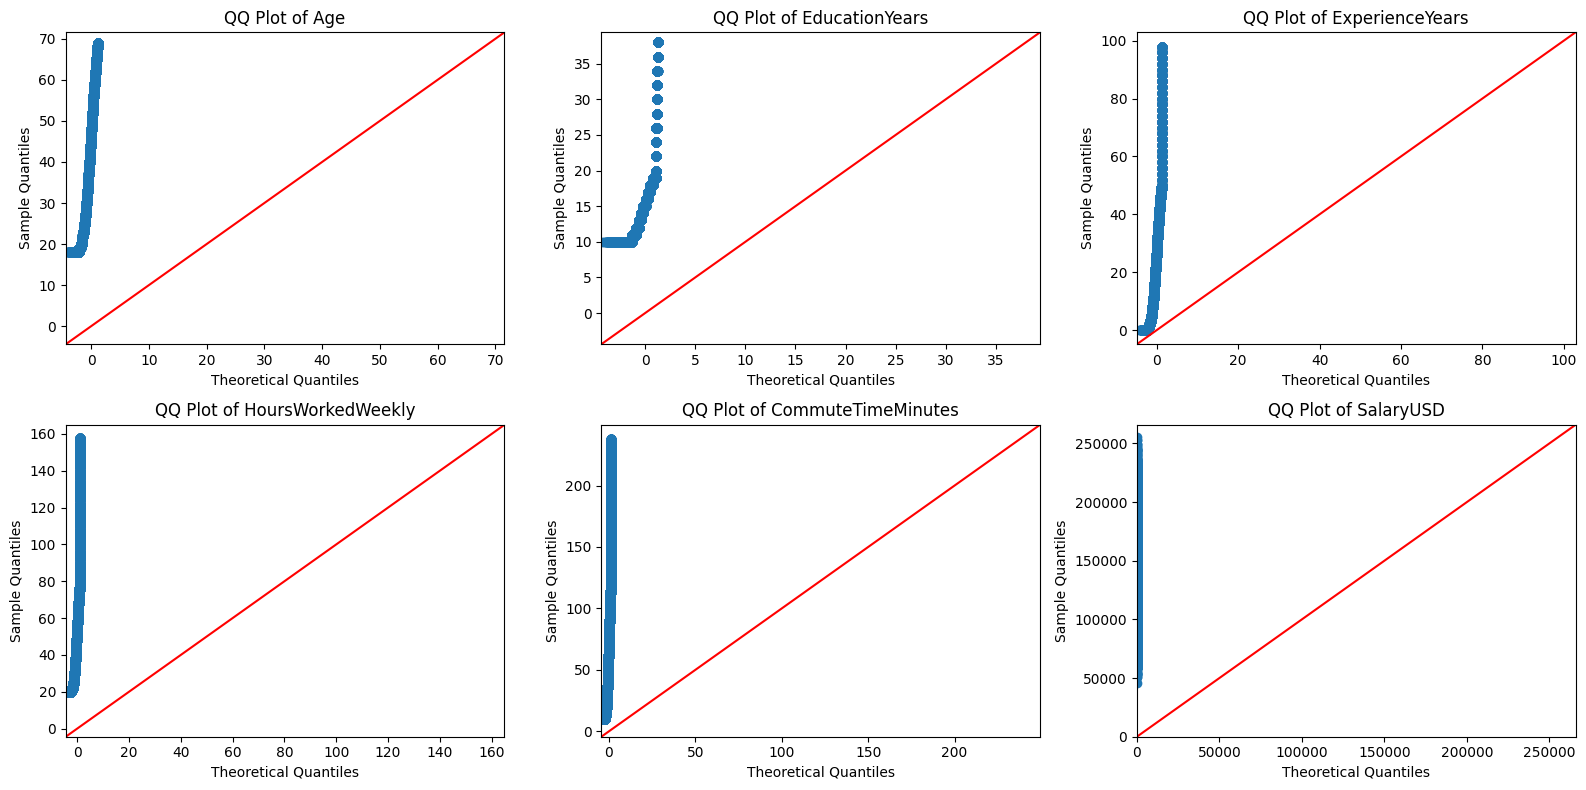

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    sm.qqplot(df[column], line ='45', ax=ax[index])
    ax[index].set_title(f"QQ Plot of {column}")

plt.tight_layout()
plt.show()

## Conclusion

- Looking at the qq-plot non of the column seems to be normal

In [21]:
num_cols

['Age',
 'EducationYears',
 'ExperienceYears',
 'HoursWorkedWeekly',
 'CommuteTimeMinutes',
 'SalaryUSD']

In [22]:
df.dtypes

Age                   float64
EducationYears        float64
ExperienceYears       float64
HoursWorkedWeekly     float64
CommuteTimeMinutes    float64
State                  object
EducationLevel         object
JobTitle               object
SalaryUSD             float64
dtype: object

#Now lets check which imputing method works best for us

In [39]:
#for numerical
s_imp_num = SimpleImputer(strategy="mean")
s_imp_mean = s_imp_num.fit_transform(df[num_cols])

#for categorical
s_imp_cat = SimpleImputer(strategy="most_frequent")
s_imp_mode = s_imp_cat.fit_transform(df[cat_cols])

#now converting categorical columns to numerical
oe = OrdinalEncoder()
cat_to_num = oe.fit_transform(s_imp_mode)

#make both back to df
df_mean = pd.DataFrame(s_imp_mean,columns=num_cols)
df_mode = pd.DataFrame(cat_to_num,columns=cat_cols)

#now concatenate both

simple_df = pd.concat([df_mean,df_mode],axis=1)


In [40]:
simple_df

,Age,EducationYears,ExperienceYears,HoursWorkedWeekly,CommuteTimeMinutes,SalaryUSD,State,EducationLevel,JobTitle
0,56.0,13.0,2.0,31.0,33.0,113651.499904,2.0,4.0,2.0
1,69.0,11.0,26.0,74.0,102.0,150812.545179,0.0,1.0,2.0
2,46.0,18.0,42.0,79.0,21.0,139168.976778,0.0,0.0,2.0
3,32.0,14.0,41.0,64.0,34.0,139829.864761,3.0,2.0,4.0
4,60.0,12.0,48.0,73.0,82.0,168962.608956,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
99995,30.0,12.0,45.0,30.0,71.0,118069.845258,0.0,3.0,0.0
99996,53.0,15.0,32.0,79.0,18.0,139805.664294,0.0,3.0,1.0
99997,33.0,17.0,48.0,26.0,105.0,135184.474124,4.0,4.0,0.0
99998,57.0,16.0,0.0,60.0,79.0,126607.842836,2.0,0.0,0.0


# Splitting data into Features and target columns (SimpleImputer)

In [41]:
x = simple_df.drop(columns="SalaryUSD")
y = simple_df["SalaryUSD"]

# Now splitting into training and testing

In [42]:
x_train , x_test  , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [44]:
lr = LinearRegression()

In [45]:
lr.fit(x_train,y_train)

LinearRegression()

In [67]:
# Make predictions on the testing set
y_pred = lr.predict(x_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R^2 Score: 0.8389375537996294
Mean Squared Error: 89621952.34874848


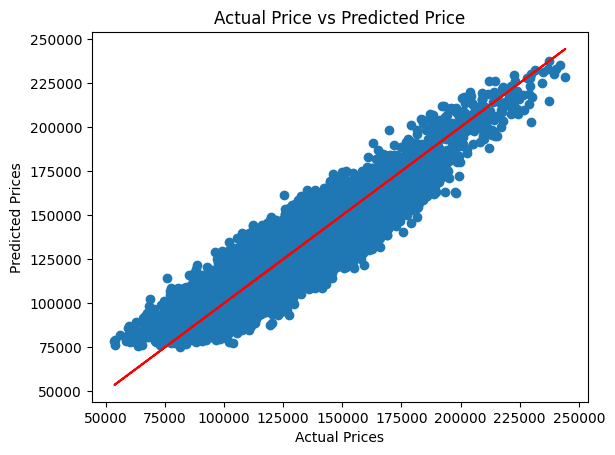

In [64]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Price vs Predicted Price")

plt.plot(y_test,y_test, color='red')

plt.show()

#Conclusion

- Without making our distributions normal we got 82 precent accuracy and very big error

## Now lets make the distributions normal and remove outliers

In [70]:
simple_df

,Age,EducationYears,ExperienceYears,HoursWorkedWeekly,CommuteTimeMinutes,SalaryUSD,State,EducationLevel,JobTitle
0,56.0,13.0,2.0,31.0,33.0,113651.499904,2.0,4.0,2.0
1,69.0,11.0,26.0,74.0,102.0,150812.545179,0.0,1.0,2.0
2,46.0,18.0,42.0,79.0,21.0,139168.976778,0.0,0.0,2.0
3,32.0,14.0,41.0,64.0,34.0,139829.864761,3.0,2.0,4.0
4,60.0,12.0,48.0,73.0,82.0,168962.608956,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
99995,30.0,12.0,45.0,30.0,71.0,118069.845258,0.0,3.0,0.0
99996,53.0,15.0,32.0,79.0,18.0,139805.664294,0.0,3.0,1.0
99997,33.0,17.0,48.0,26.0,105.0,135184.474124,4.0,4.0,0.0
99998,57.0,16.0,0.0,60.0,79.0,126607.842836,2.0,0.0,0.0


In [71]:
num_cols

['Age',
 'EducationYears',
 'ExperienceYears',
 'HoursWorkedWeekly',
 'CommuteTimeMinutes',
 'SalaryUSD']

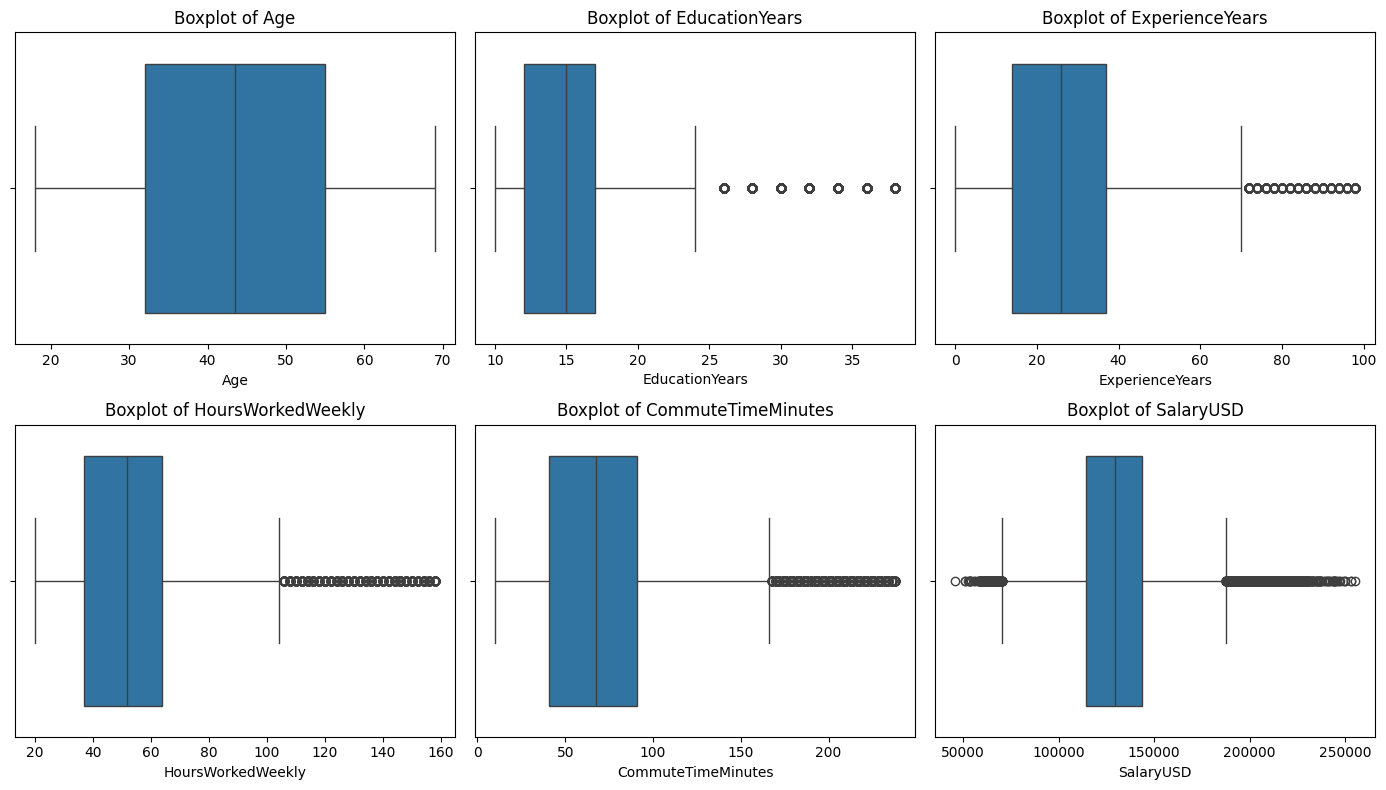

In [76]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    sns.boxplot(data=simple_df, x=simple_df[column], ax=ax[index])
    ax[index].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

#Using IQR Method

In [99]:
for column in num_cols:
    # Calculate the percentiles
    percentile25 = simple_df[column].quantile(0.25)
    percentile75 = simple_df[column].quantile(0.75)
    # Find the IQR
    iqr = percentile75 - percentile25
    # Finding the upper and lower limits
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    # Cap the outliers
    simple_df[column] = simple_df[column].clip(lower=lower_limit, upper=upper_limit)

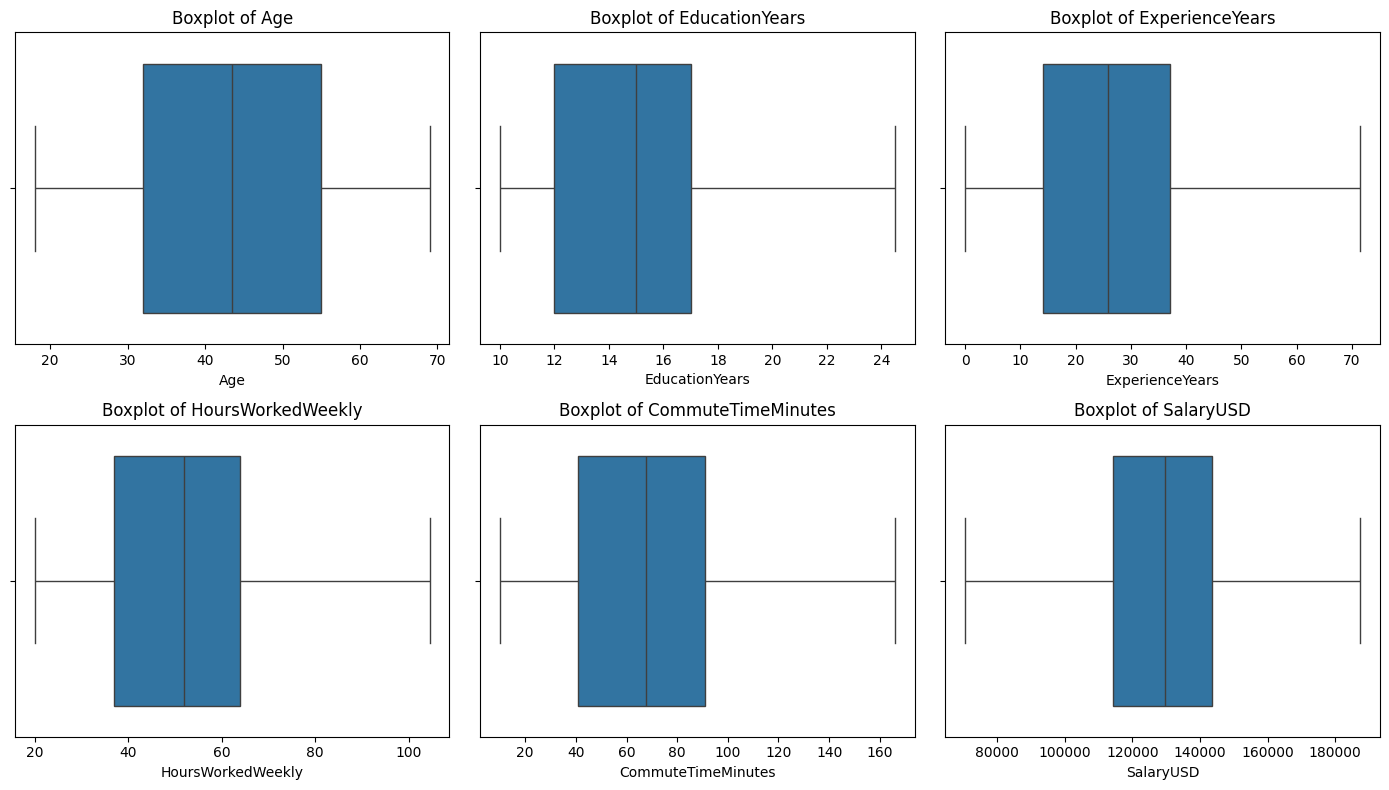

In [100]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    sns.boxplot(data=simple_df, x=simple_df[column], ax=ax[index])
    ax[index].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [106]:
pt = PowerTransformer(method='yeo-johnson')
transformed_data = pt.fit_transform(simple_df[num_cols])

simple_df[num_cols] = transformed_data

<Axes: xlabel='SalaryUSD', ylabel='Density'>

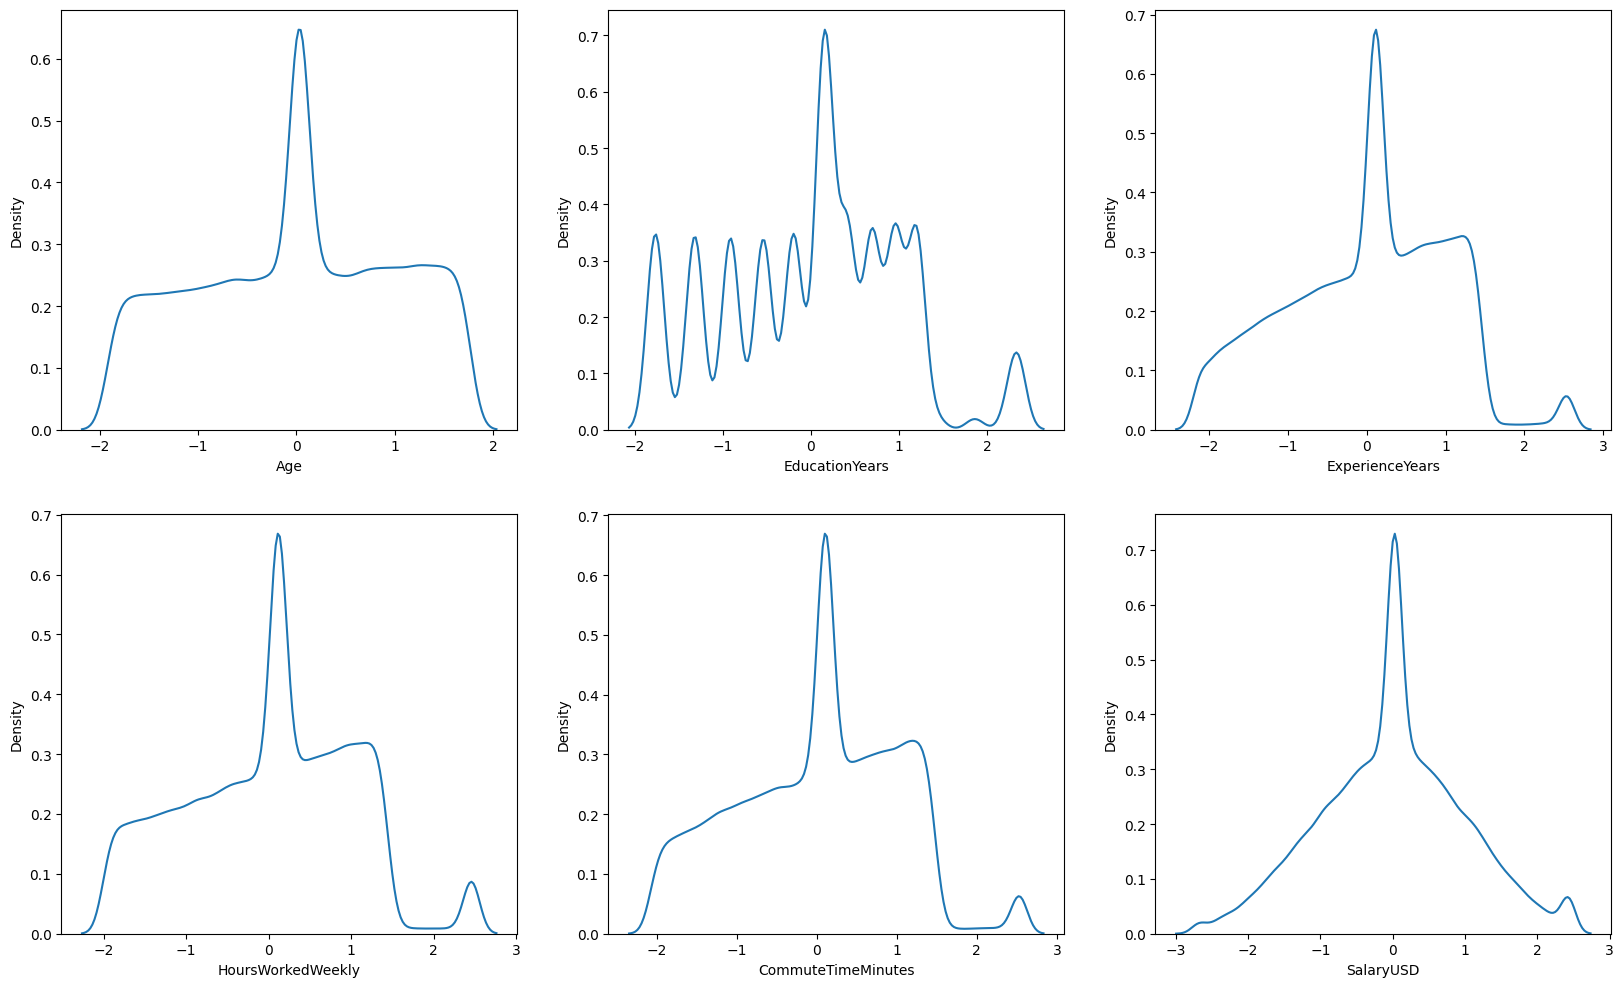

In [107]:
plt.figure(figsize=(20,12))

plt.subplot(231)
sns.kdeplot(simple_df["Age"])

plt.subplot(232)
sns.kdeplot(simple_df["EducationYears"])

plt.subplot(233)
sns.kdeplot(simple_df["ExperienceYears"])

plt.subplot(234)
sns.kdeplot(simple_df["HoursWorkedWeekly"])

plt.subplot(235)
sns.kdeplot(simple_df["CommuteTimeMinutes"])

plt.subplot(236)
sns.kdeplot(simple_df["SalaryUSD"])

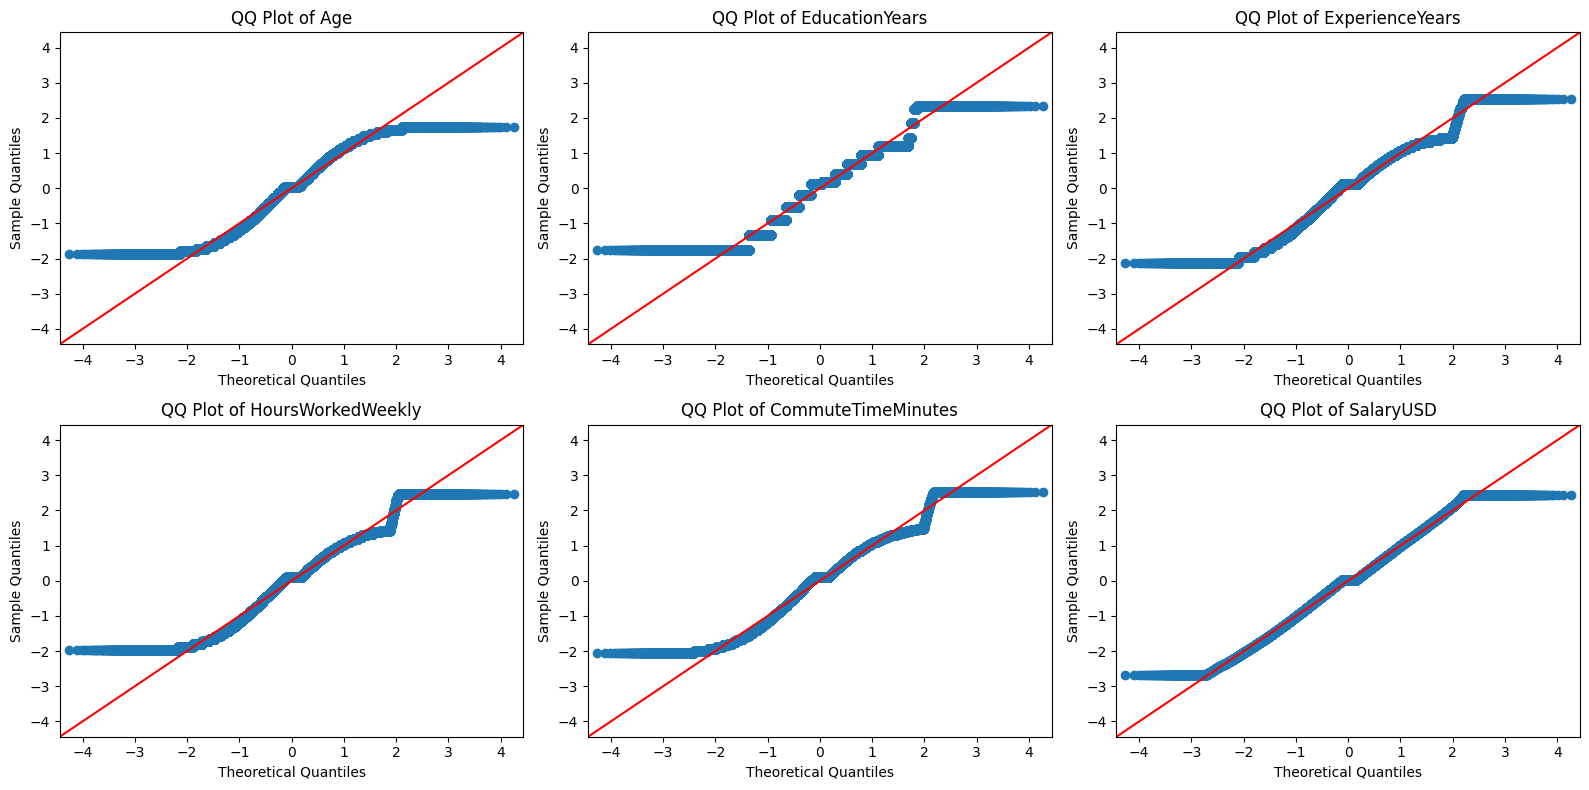

In [116]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    sm.qqplot(simple_df[column], line ='45', ax=ax[index])
    ax[index].set_title(f"QQ Plot of {column}")

plt.tight_layout()
plt.show()

In [108]:
x_clean = simple_df.drop(columns=["SalaryUSD"],axis=1)
y_clean = simple_df["SalaryUSD"]

In [109]:
X_train , X_test  , Y_train , Y_test = train_test_split(x_clean,y_clean,test_size=0.2,random_state=42)

In [110]:
lr = LinearRegression()

#fit the model
lr.fit(X_train,Y_train)

# Make predictions on the testing set
Y_pred = lr.predict(X_test)

# Calculate R^2 score
r2_clean = r2_score(Y_test, Y_pred)
print("R^2 Score:", r2_clean)

# Calculate Mean Squared Error
mse_clean = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error:", mse_clean)

R^2 Score: 0.8197911896794348
Mean Squared Error: 0.17847710153715365


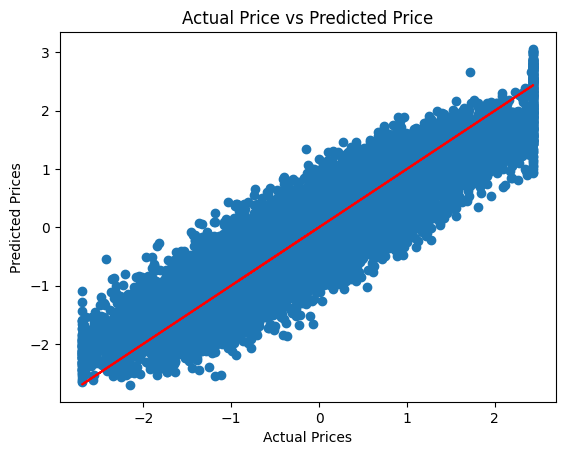

In [111]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Price vs Predicted Price")

plt.plot(Y_test,Y_test, color='red')

plt.show()

## Conclusion

- Removing the outlier and making distribution normal makes the accuracy drop but at the same time reduced the error alot

#Lets try gradient descent

In [115]:
sgd = SGDRegressor()

#fit the model
sgd.fit(X_train,Y_train)

# Make predictions on the testing set
Y_pred_sgd = sgd.predict(X_test)

# Calculate R^2 score
r2_clean_sgd = r2_score(Y_test, Y_pred)
print("R^2 Score:", r2_clean_sgd)

# Calculate Mean Squared Error
mse_clean_sgd = mean_squared_error(Y_test, Y_pred_sgd)
print("Mean Squared Error:", mse_clean_sgd)

R^2 Score: 0.8197911896794348
Mean Squared Error: 0.17870440578536895


# Conculsion

- LinearRegression works better